In [103]:
import numpy as np
from rumor_centrality import graph_simulations
from rumor_centrality import graph_generator
from tqdm import tqdm
from matplotlib import pyplot as plt
import rumor_centrality.jordan_center_alternative as jo

from rumor_centrality import rumor_detection
import networkx as nx

def predict_center(infected_graph_adj):
    return rumor_detection.get_center_prediction(rumor_detection.networkx_graph_to_adj_list(infected_graph_adj), use_fact=False)

def get_hop_distance(g, center: int, predicted_center: int):
    if not g.has_node(center) or not g.has_node(predicted_center):
        print("Center of predicted center not in graph")
    if not is_connected(g):
        return -1
    return nx.shortest_path_length(g, center, predicted_center)

def is_connected(g: nx.Graph) -> bool:
    return nx.is_directed(g) and nx.is_strongly_connected(g) or not nx.is_directed(g) and nx.is_connected(g)

def predict(model, graph, predictor_conf):
    predictor, can_handle_unconnected = predictor_conf
    infection, center = model
    if len(infection.nodes) == 0:
        return -1

    if not can_handle_unconnected and not is_connected(infection):
        return -1

    predicted = predictor(infection)
    return get_hop_distance(graph, center[0], predicted[0])

def run_sim(times, count, sim, graph, predictor_conf):
    predictions = []
    for _ in range(times):
        g = graph()
        model = sim(g, count)
        predictions.append(predict(model, g, predictor_conf))
    return predictions

def frequencies(predictions):
    values = [-1 if v is None else v for v in predictions]
    uniq_values = list(set(values))
    return dict([(u, values.count(u)) for u in uniq_values])

def matrix(n, m, p, data, row_names, col_names, max, tick_freq):
    fig, axes = plt.subplots(nrows=n, ncols=m, figsize=(12, 8), sharex='all', sharey='all')
    fig.subplots_adjust(hspace=0.1, wspace=0.1)

    for ax in axes.flat:
        ax.set_xlim([-1.5, max[0] + 0.5])
        ax.set_ylim([0, max[1]])
        ax.xaxis.set_ticks(np.arange(-1, max[0] + 1, tick_freq[0]))
        ax.yaxis.set_ticks(np.arange(0, max[1] + 1, tick_freq[1]))

    width = 0.25
    for row in range(n):
        for col in range(m):
            ax = axes[row, col]
            for bar in range(p):
                ax.bar(np.array(list(data[row][col][bar].keys())) + width * bar + width / 2 - (p * width) / 2, data[row][col][bar].values(), width=width)

            if row == n - 1:
                ax.set(xlabel=col_names[col])
            if col == 0:
                ax.set(ylabel=row_names[row])
    return fig

def valid_and_invalid(data):
    valid_data = [(hops, occurrences) for hops, occurrences in data.items() if hops != - 1]
    invalid_data = [occurrences for hops, occurrences in data.items() if hops == - 1]
    invalid_occurrences = sum(invalid_data)
    return valid_data, invalid_occurrences

def mean_of_frequency(data):
    values = []
    for hops, occurrences in data:
        values.extend([hops for _ in range(occurrences)])
    if len(values) == 0:
        return None
    return np.array(values).mean()

def avg_matrix(n, m, p, infection_counts, data, row_names, col_names, p_names, max, tick_freq):
    fig, axes = plt.subplots(nrows=n, ncols=m, figsize=(12, 8), sharex='all', sharey='all')
    fig.subplots_adjust(hspace=0.1, wspace=0.1)

    for ax in axes.flat:
        ax.set_xlim([1, max[0]])
        ax.set_ylim([0, max[1]])
        ax.xaxis.set_ticks(np.arange(0, max[0] + 1, tick_freq[0]))
        ax.yaxis.set_ticks(np.arange(0, max[1] + 1, tick_freq[1]))

    avgs = []
    invalids = []
    for row in range(n):
        avgs.append([])
        invalids.append([])
        for col in range(m):
            avgs[-1].append([])
            invalids[-1].append([])
            for bar in range(p):
                avgs[-1][-1].append([])
                invalids[-1][-1].append([])
                for i in range(len(infection_counts)):
                    valid_freq, invalid_count = valid_and_invalid(data[i][row][col][bar])
                    mean = mean_of_frequency(valid_freq)
                    avgs[-1][-1][-1].append(mean)
                    invalids[-1][-1][-1].append(invalid_count)

    colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
    for row in range(n):
        for col in range(m):
            ax = axes[row, col]
            for bar in range(p):
                ax.plot(np.array(infection_counts), avgs[row][col][bar], color=colors[bar], label=p_names[bar])
                ax.plot(np.array(infection_counts), np.array(invalids[row][col][bar]) / 50 * 10, color=colors[bar], linestyle=":", label=p_names[bar])

            if row == n - 1:
                ax.set(xlabel=col_names[col])
            if col == 0:
                ax.set(ylabel=row_names[row])
    axes[0, 0].legend()
    return fig


In [104]:
sim_si = lambda g, i: graph_simulations.si(g, -1, 0.3, 1, i, 10, True)
sim_sis = lambda g, i: graph_simulations.sis(g, -1, 0.3, 0.1, 1, i, 10, True)
sim_sir = lambda g, i: graph_simulations.sir(g, -1, 0.3, 0.1, 1, i, 10, True)
simulations = [sim_si, sim_sis, sim_sir]
sim_names = ["SI", "SIS", "SIR"]


rc_prediction = lambda infected_g: predict_center(infected_g)
jo_prediction = lambda infected_g: jo.centers_by_jordan_center(infected_g)
# bc_prediction = lambda infected_g: jo.centers_by_betweenness_centrality(infected_g)
dc_prediction = lambda infected_g: jo.centers_by_distance_centrality(infected_g)
predictors = [(rc_prediction, True), (jo_prediction, False), (dc_prediction, False)]
predictor_names = ["Rumour Centrality", "Jordan Center", "Distance Centrality"]

infection_counts = [10, 50, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]

small_world_g = lambda: graph_generator.small_world(1000, 100, 0.1)
scale_free_g = lambda: nx.Graph(graph_generator.scale_free(1000))
synthetic_internet_g = lambda: graph_generator.synthetic_internet(1000)
internet_g = lambda: graph_generator.internet()
us_power_grid_g = lambda: graph_generator.us_power_grid()
graphs = [small_world_g, scale_free_g, synthetic_internet_g, us_power_grid_g]
graph_names = ["Small World", "Scale Free", "Synthetic Internet", "US Power Grid"]

# exceptions = [(0, 2, 1), (1, 2, 1), (2, 2, 1)]


In [107]:
times = 50
data = []
for i, count in enumerate(infection_counts):
    i_data = []
    for row, sim in enumerate(simulations):
        row_data = []
        for col, graph in enumerate(graphs):
            col_data = []
            for p, predictor in enumerate(predictors):
                print(f"Running graph {graph_names[col]} with simulation {sim_names[row]} and predictor {predictor_names[p]} for {count} infections")
                col_data.append(frequencies(run_sim(times, count, sim, graph, predictor)))
            row_data.append(col_data)
        i_data.append(row_data)
    data.append(i_data)

Running graph Small World with simulation SI and predictor Rumour Centrality for 10 infections
Running graph Small World with simulation SI and predictor Jordan Center for 10 infections
Running graph Small World with simulation SI and predictor Distance Centrality for 10 infections
Running graph Scale Free with simulation SI and predictor Rumour Centrality for 10 infections
Running graph Scale Free with simulation SI and predictor Jordan Center for 10 infections
Running graph Scale Free with simulation SI and predictor Distance Centrality for 10 infections
Running graph Synthetic Internet with simulation SI and predictor Rumour Centrality for 10 infections
Running graph Synthetic Internet with simulation SI and predictor Jordan Center for 10 infections
Running graph Synthetic Internet with simulation SI and predictor Distance Centrality for 10 infections
Running graph US Power Grid with simulation SI and predictor Rumour Centrality for 10 infections
Running graph US Power Grid with sim


KeyboardInterrupt



In [6]:
import pickle
import os.path

if not os.path.exists("matrix2.pickle"):
    with open("matrix2.pickle", "wb") as f:
        print("Look Morty, I turned myself into a pickle")
        pickle.dump(data, f)


Look Morty, I turned myself into a pickle


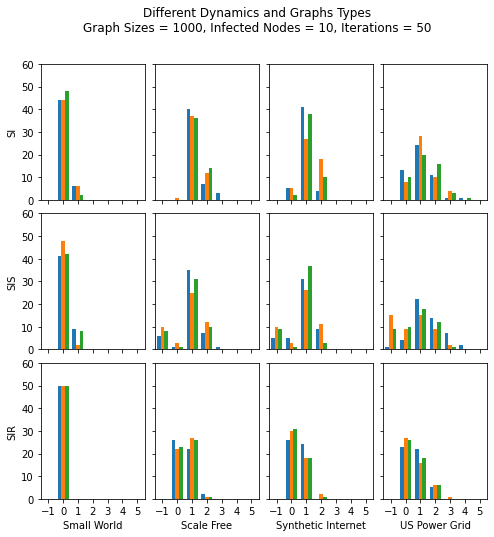

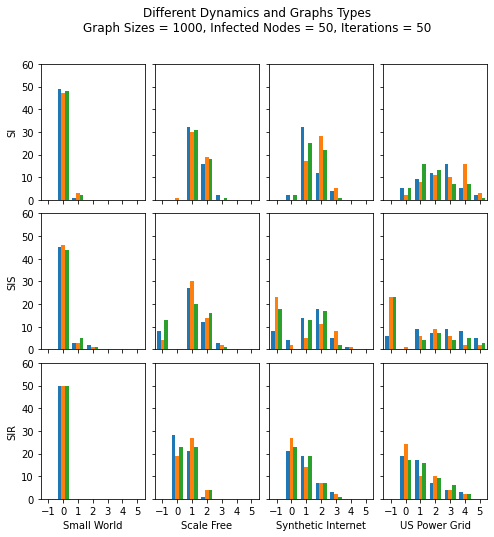

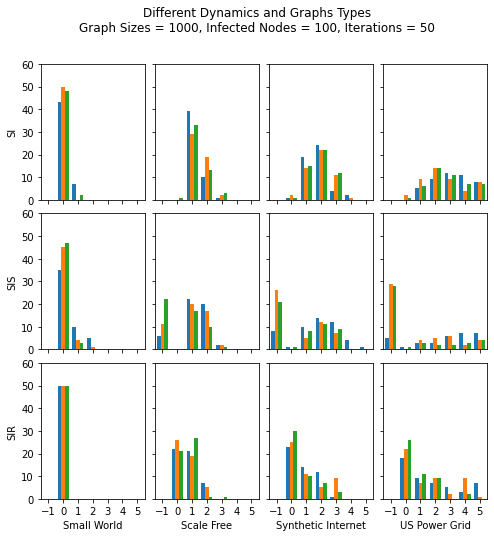

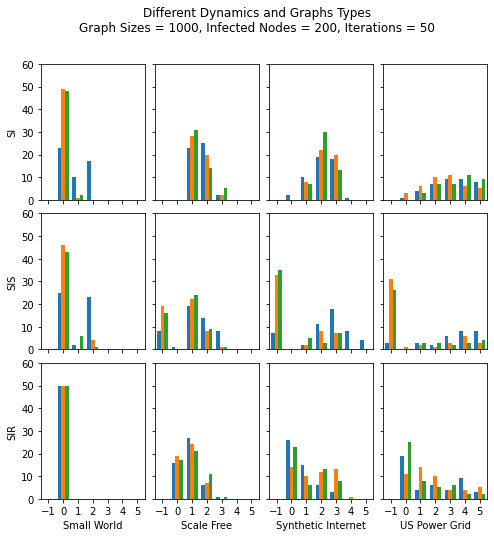

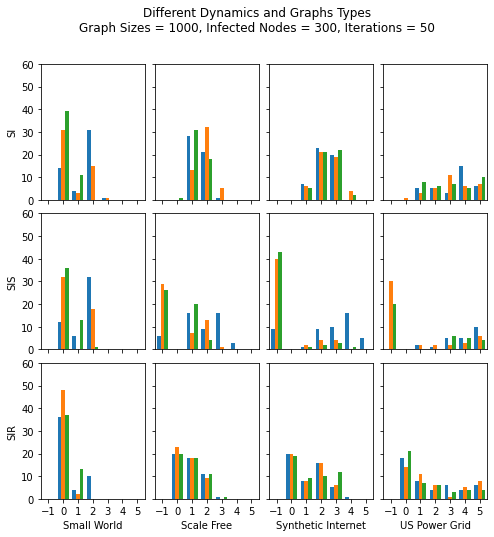

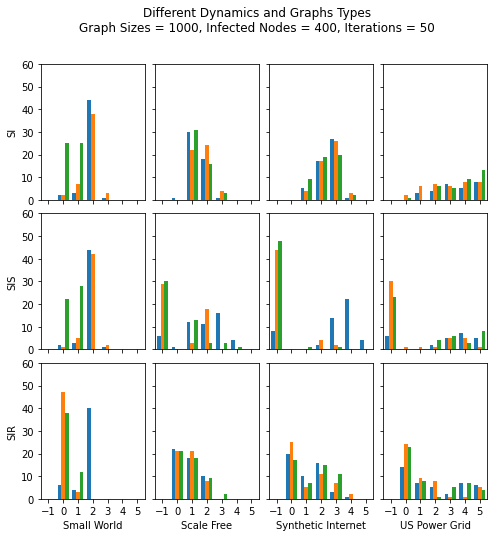

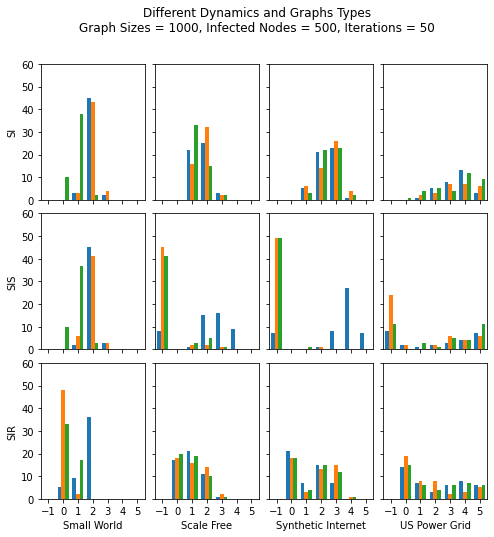

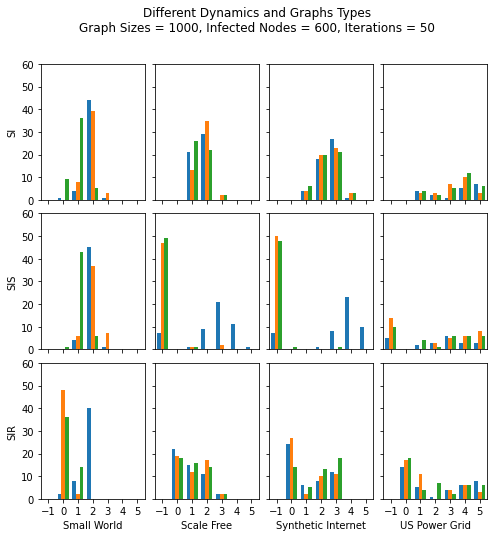

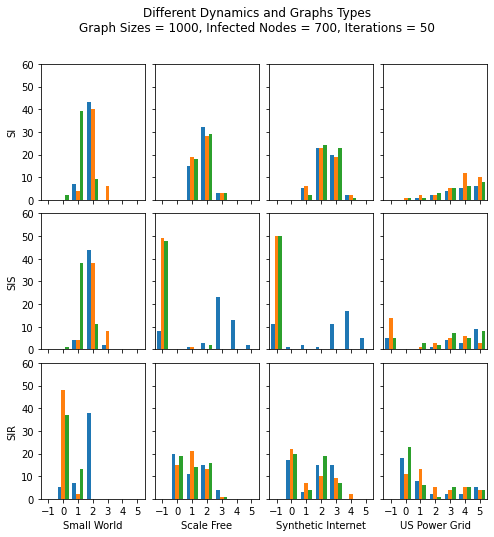

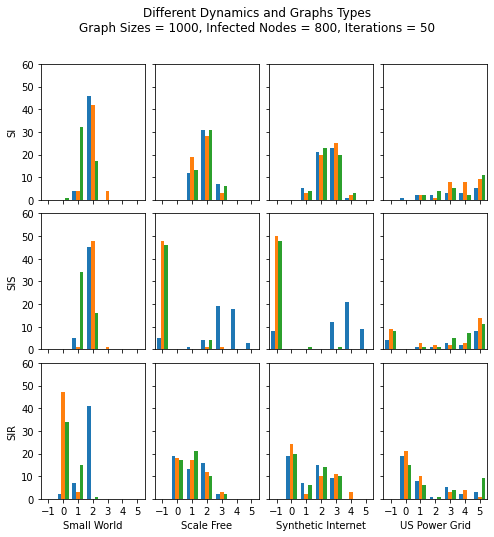

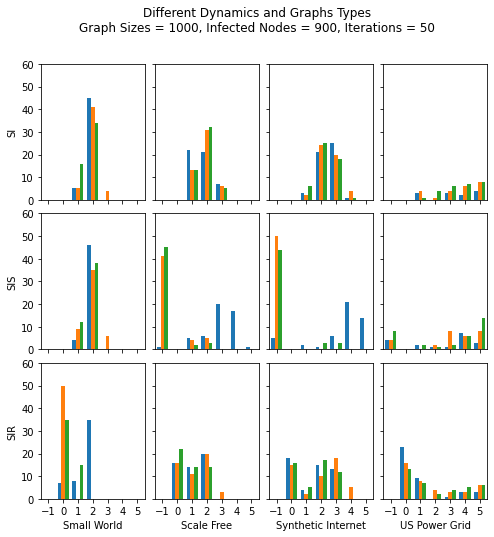

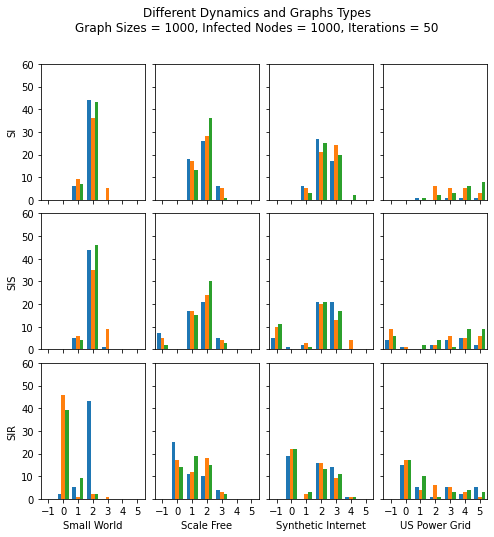

In [8]:
for i, i_data in enumerate(data):
    fig = matrix(len(simulations), len(graphs), len(predictors), i_data, sim_names, graph_names, (5, 60), (1, 10))
    fig.suptitle(f"Different Dynamics and Graphs Types\nGraph Sizes = 1000, Infected Nodes = {infection_counts[i]}, Iterations = {times}")
    plt.show()


## TODO:
- Connected Scale Free
- -1 -> Inf
- Why SIS x US Power Grid less -1: because rc works on unconnected
- Legend + same colors as Tim
- betweenness why not
- why synth internet better than us power
- additionally normalize hop distances for -1

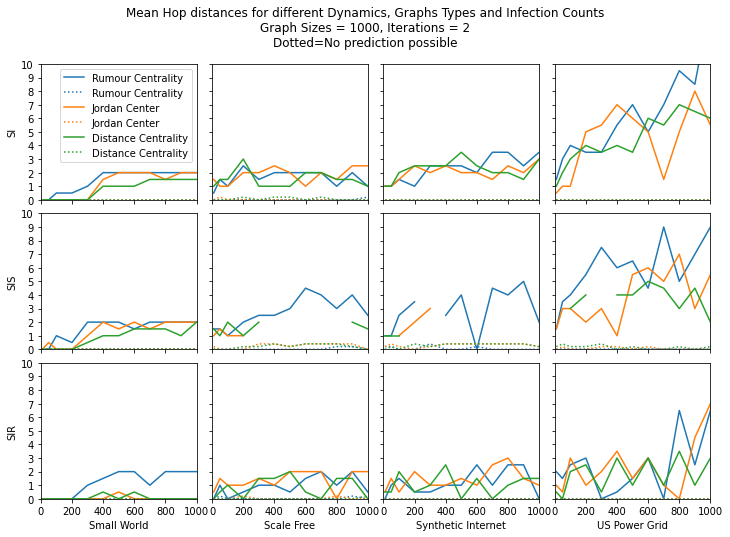

In [106]:
fig = avg_matrix(len(simulations), len(graphs), len(predictors), infection_counts, data, sim_names, graph_names, predictor_names, (1000, 10), (200, 1))
fig.suptitle(f"Mean Hop distances for different Dynamics, Graphs Types and Infection Counts\nGraph Sizes = 1000, Iterations = {times}\nDotted=No prediction possible")
plt.show()